## A. Streaming data visualization

<IPython.core.display.Javascript object>


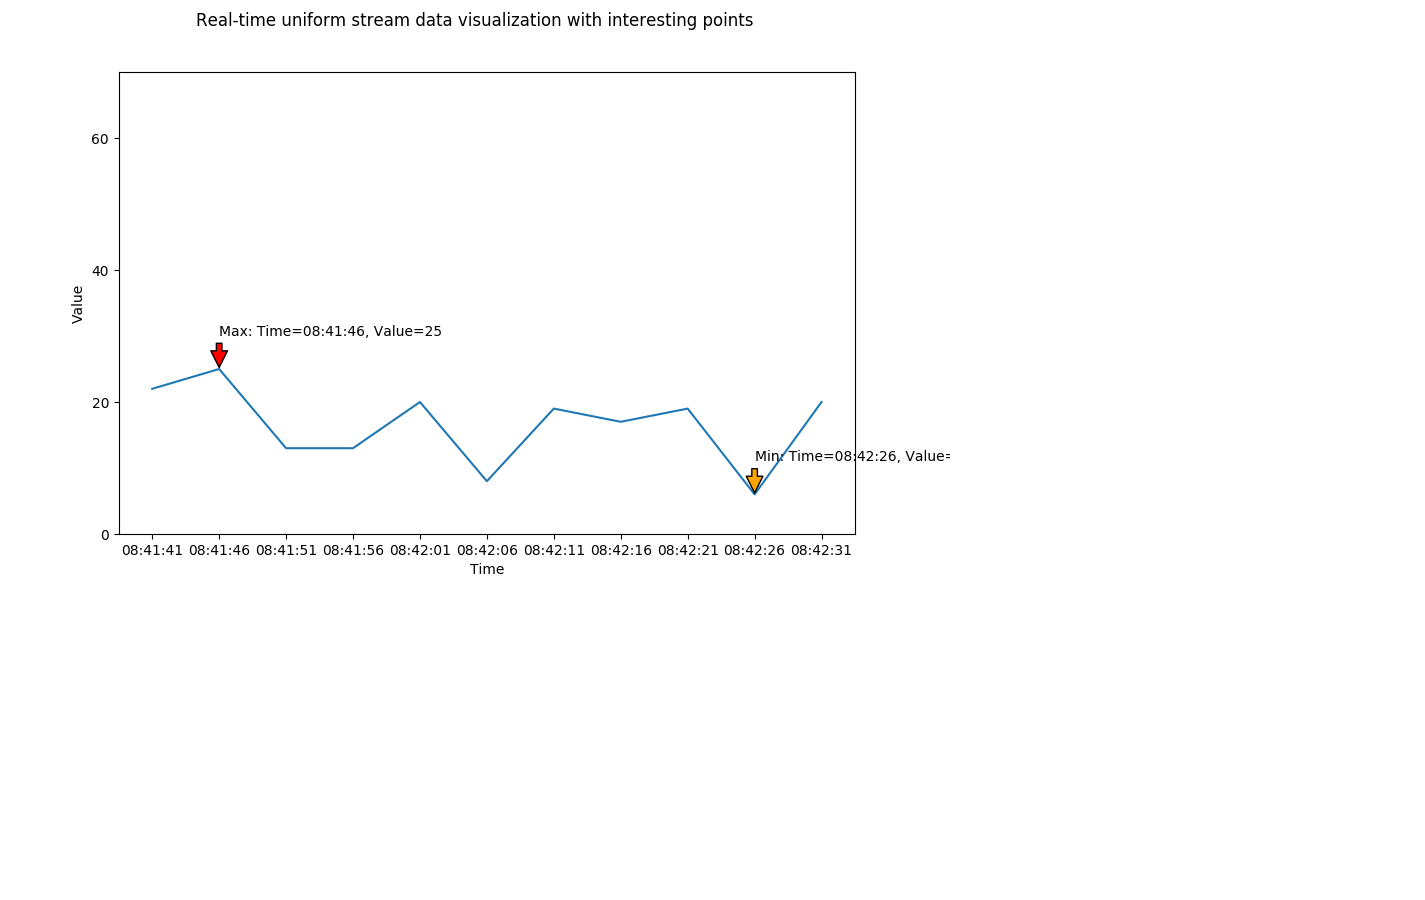

KeyboardInterrupt: 

In [1]:
# import statements
import json
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = "visual"

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = "Max: Time={}, Value={}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor="red", shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = "Min: Time={}, Value={}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor="orange", shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
#                                    auto_offset_reset="earliest", # comment this if you don"t want to consume earliest available message
                                   bootstrap_servers=["localhost:9092"],
                                   api_version=(0, 10))
    except Exception as ex:
        print("Exception while connecting Kafka")
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle("Real-time uniform stream data visualization with interesting points") # giving figure a title
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.set_ylim(0,70) 
        ax.set_yticks([0,20,40,60])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print("Waiting for messages")
        for msg in consumer:
            data = str(msg.value.decode("utf-8"))
            new_json = json.loads(data)
            time = new_json["created_time"]
            temper = new_json["air_temperature_celcius"]
            x.append(str(time))
            y.append(int(temper))
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel("Time")
                ax.set_ylabel("Value")
                ax.set_ylim(0,70) 
                ax.set_yticks([0,20,40,60])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close("all")
    except Exception as ex:
        print(str(ex))
    
if __name__ == "__main__":
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

### B. static data visualization
#### B.1 bar chart

In [4]:
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = "Scenario061"


def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
#                                    auto_offset_reset="earliest", # comment this if you don"t want to consume earliest available message
                                   bootstrap_servers=["localhost:9092"],
                                   api_version=(0, 10))
    except Exception as ex:
        print("Exception while connecting Kafka")
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle("Real-time uniform stream data visualization with interesting points") # giving figure a title
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.set_ylim(0, 20) 
        ax.set_yticks([0,3,6,9,12,15])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


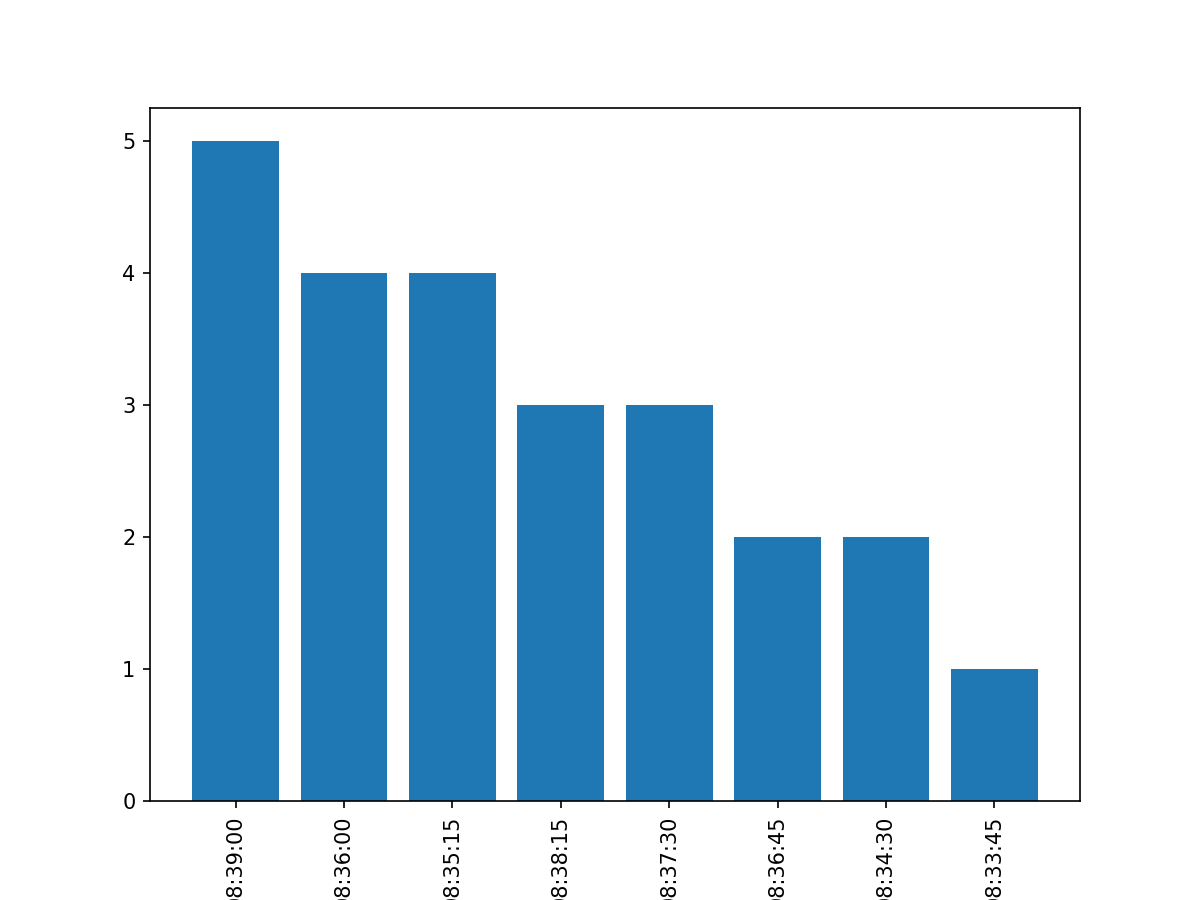

In [5]:
# static bar chart plot
import pandas as pd
import pymongo
import numpy as np

client = pymongo.MongoClient()
db = client.fit5148_db

# store the results
all_docs = []
for data in db.week11.find():
    tmp = {}
    tmp["latitude"] = data["latitude"]
    tmp["longitude"] = data["longitude"]
    tmp["created_time"] = data["created_time"]
    all_docs.append(tmp)

# store the date for latter dataframe use
dictionary = {"latitude": [], "longitude": [], "created_time": []}

for i in range(len(all_docs)):    
    dictionary["latitude"].append(all_docs[i]["latitude"])
    dictionary["longitude"].append(all_docs[i]["latitude"])
    dictionary["created_time"].append(all_docs[i]["created_time"])
df = pd.DataFrame(dictionary)

df["created_time"] = pd.to_datetime(df["created_time"])

df = df.set_index("created_time")
df = df.resample("45s").count().reset_index().loc[:, ['created_time', "latitude"]]

# modified the x and y axis
x = list(df["created_time"].apply(lambda x: str(x)[-8:]))
y = list(df["latitude"])

# plot the bar chart
plt.figure(figsize=(8, 6))
if len(y) >= 10 and len(x) >= 10:
    idx = np.argsort(y)[::-1][0:10]
    x = [x[i] for i in idx]
    y = [y[i] for i in idx]
    plt.xticks(rotation=90)
    plt.bar(x, y)
else:
    idx = np.argsort(y)[::-1]
    x = [x[i] for i in idx]
    y = [y[i] for i in idx]
    plt.xticks(rotation=90)
    plt.bar(x, y)

### B.2 Static map visualization

In [6]:
import gmplot
import webbrowser
import pymongo

client = pymongo.MongoClient()
db = client.fit5148_db

gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 7)
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"


lat_lng = {}

for each in db.climate_stream.find():
    lat_lng[(float(each["latitude"]), float(each["longitude"]))] = (each["air_temperature_celcius"], each["relative_humidity"])
    
# Looping through all the data
for row in db.week11.find():
    zi = "surface_temperature_celcius: " + str(row["surface_temperature_celcius"]) + "confidence: " + str(row["confidence"]) + " "
    default = " air_temperature_celcius: None relative_humidity: None"
    air = ""
    rela = ""
    if (float(row["latitude"]), float(row["longitude"])) in lat_lng:
        air += str(lat_lng[(float(row["latitude"]), float(row["longitude"]))][0])
        rela += str(lat_lng[(float(row["latitude"]), float(row["longitude"]))][1])
        zi += "air_temperature_celcius: "  + air + " relative_humidity: " + rela
    else:
        zi += default

    gmap.marker(float(row["latitude"]), float(row["longitude"]), title=zi)


# Drawing the map
gmap.draw("availableParkings.html")
webbrowser.open_new("availableParkings.html")

True